In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from mlxtend.frequent_patterns import apriori, fpgrowth
from sklearn.metrics.cluster import homogeneity_score, completeness_score
from sklearn import metrics
from typing import Union

# Read Data

In [79]:
df1 = pd.read_csv('heart_failure_clinical_records_dataset_binned_bool.csv')
df2 = pd.read_csv('heart_failure_clinical_records_dataset.csv')
categoric_columns = [var for var in df2.columns if len(df2[var].value_counts()) == 2]
numeric_columns = list(set(df2.columns)  - set(categoric_columns))

# Init K-Means and data + functions

In [40]:
def get_death_event_dist(X: pd.DataFrame) -> list:
    return X.groupby('DEATH_EVENT')['clusters'].apply(list)

In [41]:
def get_score_info(est: Union[KMeans, DBSCAN], n_clusters, X, labels, y, n_noise_=None, metric='euclidean') -> str:
    info = []
    if n_noise_:
        info.append(f'noise: {n_noise_}')
    info.append(f'number of clusters: {n_clusters}')
    h, c, v = metrics.homogeneity_completeness_v_measure(y, labels)
    info.append(f'homogeneity score: {h}')
    sill = 0
    if n_clusters > 1:
        sill = metrics.cluster.silhouette_score(X, labels)
        info.append(f'silhouette score: {sill}')
    return '\n'.join(info), sill, h

In [42]:
def elbow(X):
    scores = []
    for init_method in ['random', 'k-means++']:
        clusters = range(1, 30)
        for k in clusters:
            kmeans = KMeans(init=init_method, n_clusters=k, random_state=10)
            scores.append(kmeans.fit(X).inertia_)
        plt.plot(clusters, scores, marker='o')
        plt.title(f'Elbow Method for using {init_method} init method')
        plt.xticks(clusters)
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()
        scores = []

In [59]:
def get_bins(df, n, encode, strat):
    global numeric_columns
    binner = KBinsDiscretizer(n_bins=n, encode=encode, strategy=strat)
    X = pd.DataFrame(binner.fit_transform(df[numeric_columns]))
    X.columns = numeric_columns
    for cat in categoric_columns:
        X[cat] = df[cat]
    return X

In [44]:
def run_kmeans2(X: pd.DataFrame, y, clusters, rs):
    kms = []
    for init_method in ['random', 'k-means++']:
        for k in clusters:
            data = X.copy()
            kmeans = KMeans(n_clusters=k, init=init_method, random_state=rs)
            data['clusters'] = kmeans.fit_predict(data)
            reduced_data = PCA(n_components=2).fit_transform(data)
            results = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
    
            score_info, sill, h = get_score_info(kmeans, k, results, data['clusters'], y)
            plt.figure(figsize=(7, 7))
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
            sns.scatterplot(x='PCA1', y='PCA2', hue=kmeans.labels_, data=results)
            ax = plt.gca()
            ax.grid(False)
            plt.text(0.33, -0.15, score_info, transform=ax.transAxes, verticalalignment='top', bbox=props)
            plt.title(f'K-means Clustering with k={k} and {init_method} init')
            plt.show()
        kms.append(data)

    return kms

In [45]:
def run_kmeans(X: pd.DataFrame, y, k_random, k_kpp, random_state):
    kms = []
    for k, init_method in zip([k_random, k_kpp], ['random', 'k-means++']):
        data = X.copy()
        kmeans = KMeans(n_clusters=k, init=init_method, random_state=random_state)
        data['clusters'] = kmeans.fit_predict(data)
        # we need to perform a linear transormation in order to plot it in R^2
        reduced_data = PCA(n_components=2).fit_transform(data)
        results = pd.DataFrame(reduced_data, columns=['PCA1', 'clusters'])

        score_info, sill, h = get_score_info(kmeans, k, results, data['clusters'], y)
        plt.figure(figsize=(7, 7))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        sns.scatterplot(x='PCA1', y='clusters', hue=kmeans.labels_, data=results)
        ax = plt.gca()
        ax.grid(False)
        plt.text(0.33, -0.15, score_info, transform=ax.transAxes, verticalalignment='top', bbox=props)
        plt.title(f'K-means Clustering with k={k} and {init_method} init')
        plt.show()
        kms.append(data)

    return kms

# Elbow method on df1

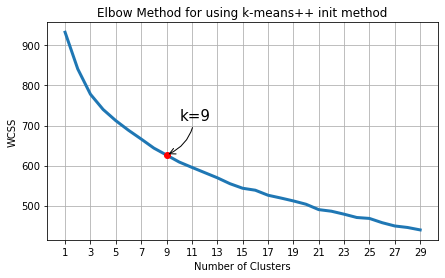

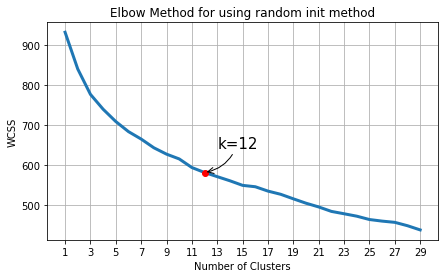

In [46]:
X1 = df1.copy()
from kneed import KneeLocator
def plot_elbow_and_return_k(X: pd.DataFrame) -> list:
    """ returns the best K(s) param after testing for both k++ and random init"""
    sse, knees = [], {}
    clusters = range(1, 30)
    for init_method in ['k-means++', 'random']:
        for k in clusters:
            kmeans = KMeans(n_clusters=k, random_state=42, init=init_method)
            kmeans.fit(X)
            sse.append(kmeans.inertia_)
        knee = KneeLocator(clusters, sse, curve="convex", direction="decreasing").elbow + 1
        plt.figure(figsize=(7, 4))
        plt.title(f'Elbow Method for using {init_method} init method')
        plt.xticks(range(1, 30, 2))
        plt.grid(True)
        plt.plot(clusters, sse, linewidth=3)
        plt.xlabel("Number of Clusters")
        plt.ylabel("WCSS")
        plt.plot(knee, sse[knee-1], 'ro')
        ax = plt.gca()
        ap = {'arrowstyle': "->", 'connectionstyle': 'arc3,rad=-0.3'}
        ax.annotate(f'k={knee}', (knee, sse[knee-1]), (knee+1, sse[knee-5]), arrowprops=ap, fontsize=15)
        plt.show()
        sse = []
        knees[init_method] = knee
    return knees

knees = plot_elbow_and_return_k(X1)

# K-Means

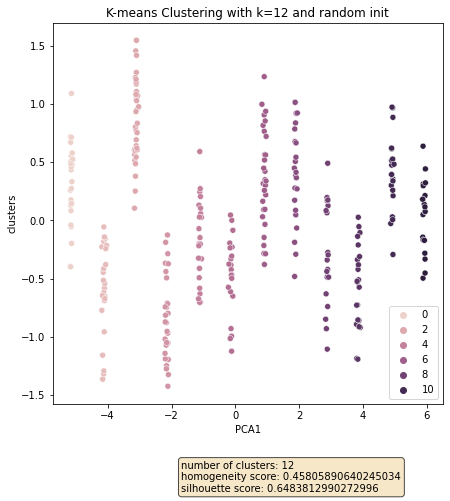

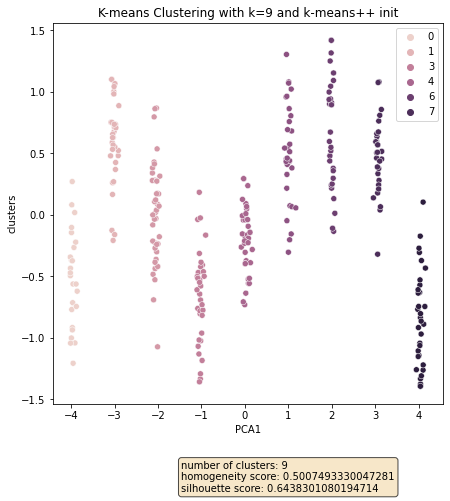

In [47]:
X1, y1 = df1.copy(), df1['DEATH_EVENT']
k_random, k_kpp, random_state = knees['random'], knees['k-means++'], 42
r, k = run_kmeans(X1, y1, k_random, k_kpp, random_state)

# DBSCAN
## epsilon determination

In [86]:
from sklearn.neighbors import NearestNeighbors
def plot_nn_for_eps(df):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(df)
    distances, indices = nbrs.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.title(f'Nearest-Neighbours')
    plt.show()

def get_reduced(df: pd.DataFrame, components):
    data = PCA(n_components=components).fit_transform(df)
    data = pd.DataFrame(data, columns=[f'pca{i}' for i in range(1, components+1)])
    return data

In [97]:
def run_dbscan(X: pd.DataFrame, y, e, n_e, components=2):
    dbs = []
    for metric in ['euclidean', 'manhattan']:
        data = X.copy()
        # init dbscan
        data = get_reduced(data, components)
        dbscan = DBSCAN(eps=e, min_samples=n_e, metric=metric)
        # fit prdict
        data['clusters'] = dbscan.fit_predict(data)
        dbs.append(data)
        # get labels to get noise and n_clusters
        labels = dbscan.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        hom, comp = homogeneity_score(y, data['clusters']), completeness_score(y, data['clusters'])
        # reduction for R^2
        results = get_reduced(data, 2)
        reduced_X = PCA(n_components=2).fit_transform(data)
        results = pd.DataFrame(reduced_X, columns=['pca1','pca2'])
        # get score and info
        score_info, sill, h = get_score_info(dbscan, n_clusters_, data, labels, y, n_noise_=n_noise_)
        plt.figure(figsize=(7, 7))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        sns.scatterplot(x='pca1', y='pca2', hue=labels, data=results, legend='full')
        ax = plt.gca()
        plt.text(0.33, -0.15, score_info, transform=ax.transAxes, verticalalignment='top', bbox=props)
        plt.title(f'DBSCAN with {n_clusters_} clusters, epsilon={e}, N_e(x)={dbscan.min_samples}, metric={metric}')
        plt.show()
    return dbs

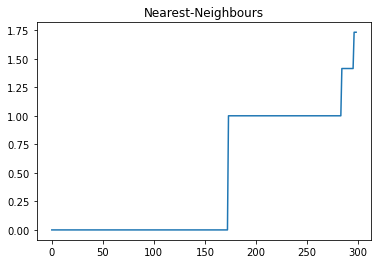

In [98]:
n_bins = 2
X2 = get_bins(df2, n_bins, 'ordinal', 'uniform')
plot_nn_for_eps(X2)

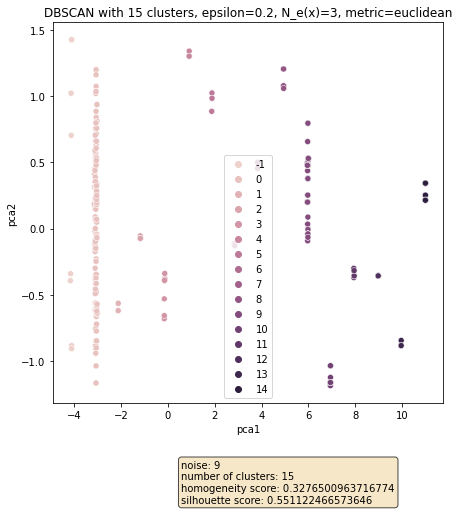

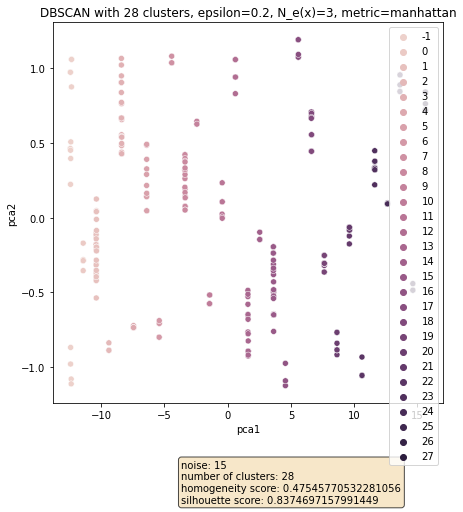

[         pca1      pca2  clusters
 0    0.248622  1.078337         0
 1   -0.117196  0.532391         0
 2   -0.567131  0.760647         1
 3    0.228495  0.579988         0
 4    1.071386 -0.075914         0
 ..        ...       ...       ...
 294 -0.647804 -0.357859         0
 295 -0.123711 -0.807149         9
 296  0.258532 -1.173824        14
 297 -1.183620 -0.236383        10
 298 -1.183620 -0.236383        10
 
 [299 rows x 3 columns],
          pca1      pca2  clusters
 0    0.248622  1.078337         0
 1   -0.117196  0.532391         1
 2   -0.567131  0.760647         2
 3    0.228495  0.579988         1
 4    1.071386 -0.075914         3
 ..        ...       ...       ...
 294 -0.647804 -0.357859        19
 295 -0.123711 -0.807149        23
 296  0.258532 -1.173824        27
 297 -1.183620 -0.236383        20
 298 -1.183620 -0.236383        20
 
 [299 rows x 3 columns]]

In [99]:
epsilon, neighbours, components = .2, 3, 2
run_dbscan(X2, y1, epsilon, neighbours, components)